<p style="text-align: center;" ><font size="+3"><u><b>Laboratory 4 Part 1: Optical System Modeling with Aberrations</u></b></p>

<p style="text-align: left;" ><font size="+1"><b>Group #: 7   Team Members: Charissa Luk, William Li, Anna Vargas  </b></p>

<p style="text-align: left;" ><font size="+1"><b>Objectives</b></p>

<div class="alert alert-block alert-warning">
<font color=black>

- Understand and be able to model optical phase aberrations
- Build realistic models of optical systems
- Understand basic concepts of optimization
- Identify system parameters in real data through an optimization process

</font>
</div>

<p style="text-align: left;" ><font size="+1"><b>Introduction / Basic Rules</b></p>

<div class="alert alert-block alert-warning">
<font color='black'>

In this lab, you will extend the ideal optical model from Lab 3 to a more realistic optical system. In Part 1 of this lab, we will learn to model optical phase aberrations, and then look at how aberrations affect the PSF and the final image. <br/>
    
In Part 2, we will collect real data and apply the model you build in Part 1 to identify system parameters through an optimization process. <br/>
    
Recall from class notes and discussions that our new model of the coherent PSF is:
\begin{equation}
\large
h(u,v) = \frac{A}{\lambda z_i} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \mathcal{P}(x,y) \hspace{5px} \exp \bigg\{ -i \frac{2\pi}{\lambda z_i} (ux+vy)\bigg\} dx dy
\large
\end{equation}
    
\begin{equation}
\large
\mathcal{P}(u,v) = \underbrace {P(u,v)}_{\text{amplitude}} \hspace{5px} \underbrace {\exp \big[ i \frac{2\pi}{\lambda} W(u,v) \big]}_{\text{phase}}
\large
\end{equation}
    
And remember that we are adopting a generalized pupil function with two parts: amplitude and phase.
</font>
</div>

# Generalized Pupil Function - Amplitude

<div class="alert alert-block alert-warning">
<font color=black>

Since our image is measured on the image plane (camera), it is easier for modeling purposes if we scale all the axes to the image plane. That is, we consider spatial domain and Fourier domain axes with a sampling interval based on the pixel size of the camera, 5.3 $\mu$m. <br/>

</font>
</div>

In [1]:
  from google.colab import drive
  drive.mount('/content/drive')

  import sys
  sys.path.append('/content/drive/MyDrive/1. EN.580.494.01 Build an Imager/Build_Imager/Lab4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
  import functions
  import zernike

<div class="alert alert-block alert-success">
<font color=black>

1. Specify the spatial domain and frequency domain axes ($x, y, f_x, f_y$) of a 1001 by 1001 image with sampling interval 5.3 $\mu$m. Write this code below:
</font>
</div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt


grid = 1001
sampling = 0.0053
x = np.linspace(-2.65, 2.65, grid)
y = np.linspace(-2.65, 2.65, grid)
X, Y = np.meshgrid(x, y)

fx = np.fft.fftshift(np.fft.fftfreq(grid, d=sampling))
fy = np.fft.fftshift(np.fft.fftfreq(grid, d=sampling))

print(x)
print(500*sampling)

[-2.65   -2.6447 -2.6394 ...  2.6394  2.6447  2.65  ]
2.65


<div class="alert alert-block alert-warning">
<font color=black>

If one takes the Fourier transform of both sides of the above expression for the coherent PSF, we can obtain the Fourier transform of $h$ directly. Specifically, this can be achieved by a change of axes in the pupil function.  For example, for a circular aperture of radius $r$, the amplitude of the <u> Fourier transform of $h$</u> (denoted $H$) is given by:
    
- `FX, FY = np.meshgrid(-lambd*zi*fx, -lambd*zi*fy)`. Note that `lambda` is a Python keyword reserved for anonymous function, so we will try to avoid naming a variable after it.
- `H = (FX**2 + FY**2) < r**2`
                              
`lambd` is the wavelength (e.g., 540 nm for “green” light and 600 nm for “red” light) and the `zi` is image distance (i.e., the distance from the pupil to the image plane). For now, let’s assume `zi` is 300 mm, and `r` is 2mm.
</font>
</div>

<div class="alert alert-block alert-success">
<font color=black>

2. Simulate the PSF (recall that incoherent PSF is $|h|^2$) of the red and green light. Show the PSF and log10 PSF images below. Zoom in on the central 201 by 201 elements and use colormap `jet`. <br/>
<u> (Note: Throughout this lab, please use colormap `jet` for PSF and OTF images and colormap `gray` for all simulated object images.) </u>
</font>
</div>

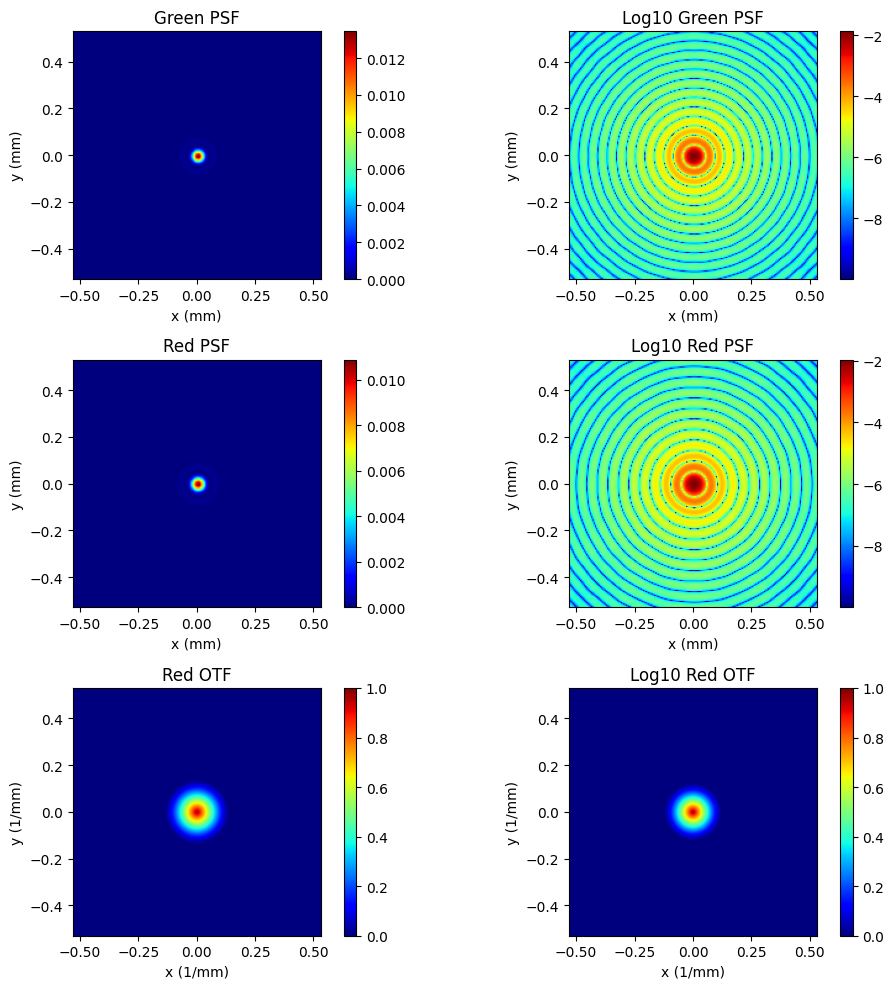

In [4]:
zi = 300  # mm
r = 2  # mm
wavelengths = {'green': 540E-6, 'red': 600E-6}  # nm

def simulate_psf(lambd):
    FX, FY = np.meshgrid(-lambd*zi*fx, -lambd*zi*fy)
    H = (FX**2 + FY**2) < r**2
    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))

    psf = np.abs(h)**2
    psf /= psf.sum()
    return psf


psf_green = simulate_psf(wavelengths['green'])
psf_red = simulate_psf(wavelengths['red'])

otf_green = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(psf_green)))
otf_red = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(psf_red)))
otf_green_abs = np.abs(otf_green)
otf_red_abs = np.abs(otf_red)


center = grid // 2
zoom = 100
psf_green_zoom = psf_green[center-zoom:center+zoom+1, center-zoom:center+zoom+1]
psf_red_zoom = psf_red[center-zoom:center+zoom+1, center-zoom:center+zoom+1]

extent = np.array([x.min(), x.max(), y.min(), y.max()])
zoom = np.divide(extent, 5.0)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

im00 = axs[0, 0].imshow(psf_green_zoom, cmap='jet', extent=zoom)
axs[0, 0].set_title("Green PSF")
axs[0, 0].set_xlabel("x (mm)")
axs[0, 0].set_ylabel("y (mm)")
fig.colorbar(im00, ax=axs[0, 0])

im01 = axs[0, 1].imshow(np.log10(psf_green_zoom + 1e-10), cmap='jet', extent=zoom)
axs[0, 1].set_title("Log10 Green PSF")
axs[0, 1].set_xlabel("x (mm)")
axs[0, 1].set_ylabel("y (mm)")
fig.colorbar(im01, ax=axs[0, 1])

im10 = axs[1, 0].imshow(psf_red_zoom, cmap='jet', extent=zoom)
axs[1, 0].set_title("Red PSF")
axs[1, 0].set_xlabel("x (mm)")
axs[1, 0].set_ylabel("y (mm)")
fig.colorbar(im10, ax=axs[1, 0])

im11 = axs[1, 1].imshow(np.log10(psf_red_zoom + 1e-10), cmap='jet', extent=zoom)
axs[1, 1].set_title("Log10 Red PSF")
axs[1, 1].set_xlabel("x (mm)")
axs[1, 1].set_ylabel("y (mm)")
fig.colorbar(im11, ax=axs[1, 1])

im20 = axs[2, 0].imshow(otf_green_abs, cmap='jet', extent=zoom)
axs[2, 0].set_title("Red OTF")
axs[2, 0].set_xlabel("x (1/mm)")
axs[2, 0].set_ylabel("y (1/mm)")
fig.colorbar(im20, ax=axs[2, 0])

im21 = axs[2, 1].imshow(otf_red_abs, cmap='jet', extent=zoom)
axs[2, 1].set_title("Log10 Red OTF")
axs[2, 1].set_xlabel("x (1/mm)")
axs[2, 1].set_ylabel("y (1/mm)")
fig.colorbar(im21, ax=axs[2, 1])

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
<font color=black>

3. Simulate what the star pattern looks like when the system is illuminated with red light and green light. What is the difference between the two images? How does wavelength affect the resolution of the system?
</font>
</div>

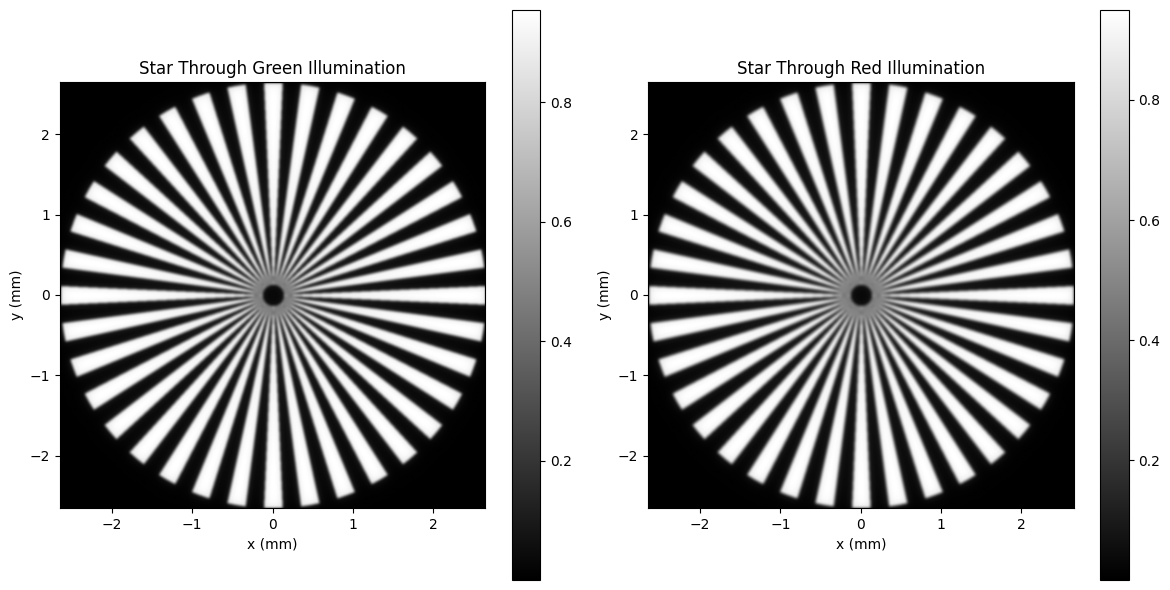

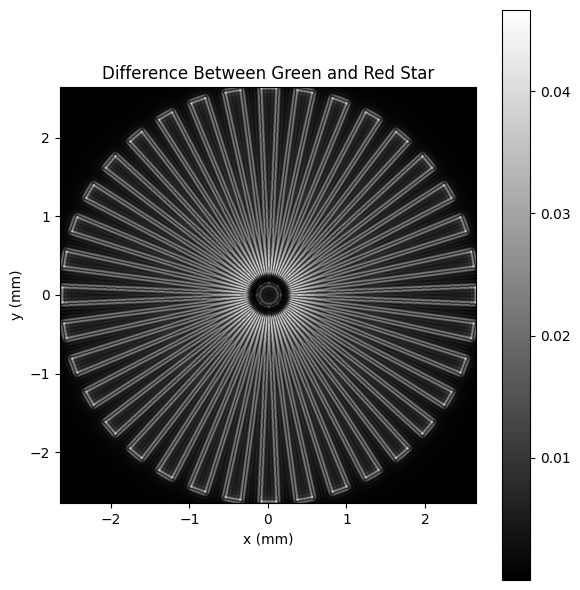

In [5]:
from functions import make_star
from scipy.signal import fftconvolve

star = make_star(x, y)

star_red = fftconvolve(star, psf_red, mode='same')
star_green = fftconvolve(star, psf_green, mode='same')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im0 = axs[0].imshow(star_green, cmap='gray', extent=extent)
axs[0].set_title("Star Through Green Illumination")
axs[0].set_xlabel("x (mm)")
axs[0].set_ylabel("y (mm)")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(star_red, cmap='gray', extent=extent)
axs[1].set_title("Star Through Red Illumination")
axs[1].set_xlabel("x (mm)")
axs[1].set_ylabel("y (mm)")
fig.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

diff = np.abs(star_green - star_red)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(diff, cmap='gray', extent=extent)
ax.set_title("Difference Between Green and Red Star")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

We observe that with the green illumination we can resolve finer details which is especialy apparent in the center of the start. This is because of its shorter wavelength and thus higher frequency which allows it to preserve these features. Meanwhile, the longer wavelength and lower frequency does not preserve small details in the star. The difference image between the green and red star show sharp outlines along the star's edges, emphasizing where green light resolves features that appear blurred under red illumination—particularly at high spatial frequencies near the center and spokes.

# Generalized Pupil Function - Phase

<div class="alert alert-block alert-warning">
<font color=black>

Download `zernike.py` and `zernike_index.npy` from Blackboard Lab 4 Course Content. The zernike function yields the weighted sum of multiple Zernike polynomials. You may import the `zernike` function using the following command:

`from zernike import zernike`

The syntax of the function is as follows: <br/>

`z_sum = zernike(-lambd*zi*fx/r, -lambd*zi*fy/r, mode_indices, coefs)`
    
where `mode_indices` a vector of the mode indices, and `coefs` are the coefficients for the Zernike polynomials at the corresponding mode index.
</font>
</div>

<div class="alert alert-block alert-warning">
<font color=black>

In the notes, Zernike polynomials are indicated by $Z_n^m$, where $n$ is the order, and $m$ is the frequency. The mode index `i` (using the Noll index convention) is another way of indexing the polynomials and is related to $n$,$m$ via the following table for the few polynomials we will be using today.
</font>
</div>

<img src="Lab4\Zernike.png" style="width:800px">

<div class="alert alert-block alert-warning">
<font color=black>

For example, to get the Zernike polynomial of x-tilt of coefficient 1, defocus of coefficient 2, and y-coma of coefficient 3, you could specify the `mode_indices` and `coefs` as follows:
    
`mode_indices = [2, 4, 7]` <br/>
`coefs = [1, 2, 3]`
    
The phase portion of the Fourier transform of `h` is then given by <br/>
`np.exp(-1j*2*np.pi*z_sum)`<br/>
    
To combine the amplitude and phase, we can do the following, which gives us the Fourier transform of $h$ with phase aberrations: <br/>
`H*np.exp(-1j*2*np.pi*z_sum)`<br/>

You can then compute $h$ via an inverse Fourier transform, take the absolute value squared to obtain the incoherent point spread function. <br/>

Now let’s simulate several aberrations and see how they affect the image. <u>For all simulations below, set the wavelength to green at 540 nm.</u> Keep system parameters like pupil radius and distance from lens to camera the same as the red/green PSF experiment above. <br/>
</font>
</div>

<div class="alert alert-block alert-success">
<font color=black>

1. Simulate an x-tilt of coefficient 0.5. Show images of the PSF and log10 PSF, both zoomed in on the central 201 by 201 elements. Also show the absolute value of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image.

</font>
</div>

In [6]:
import os
os.listdir('/content/drive/MyDrive/1. EN.580.494.01 Build an Imager/Build_Imager/Lab4')


['functions.py',
 'Zernike.png',
 'zernike_index.npy',
 'OptimizationExample.ipynb',
 '__pycache__',
 'Lab4 Part1 (Clean) (1).ipynb',
 'Lab4 Part1 (Clean).ipynb',
 'zernike.py',
 'Lab4 Part1 (Clean) (github).ipynb',
 'Lab4 Part2 (Clean).ipynb',
 'Lab4 Part 1 Writeup.gdoc']

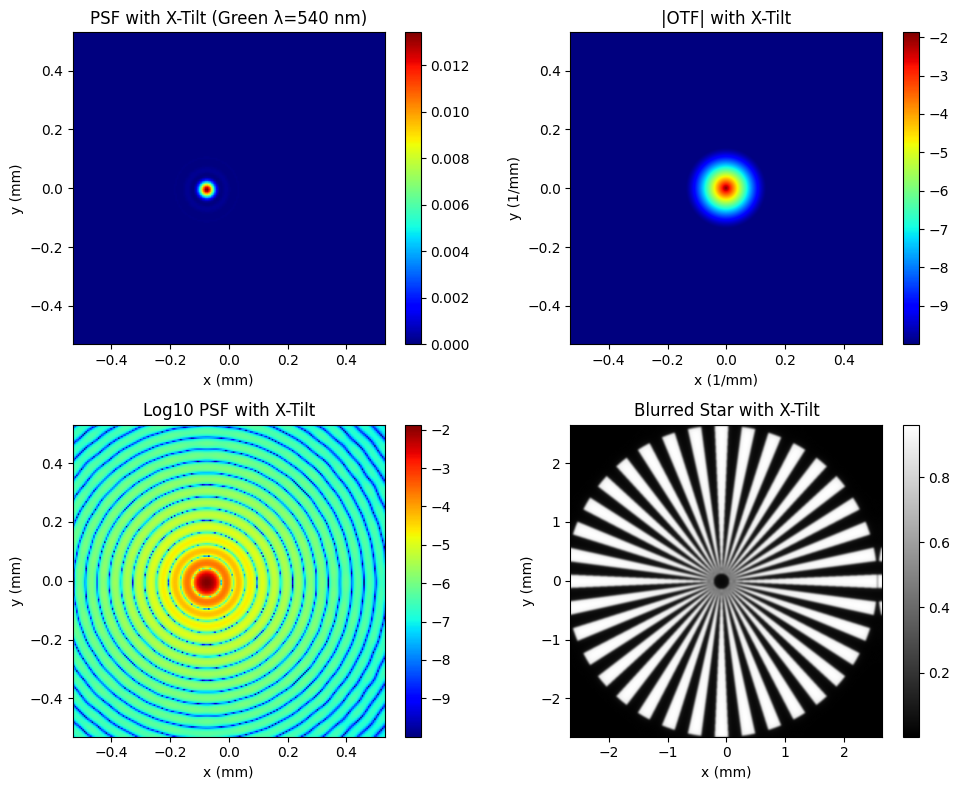

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
from zernike import zernike

zernike_index = np.load('/content/drive/MyDrive/1. EN.580.494.01 Build an Imager/Build_Imager/Lab4/zernike_index.npy')


grid = 1001
dx = 0.0053  # mm


def simulate_psf_with_aberration(lambd):
    FX, FY = np.meshgrid(-lambd*zi*fx, -lambd*zi*fy)
    H_amp = (FX**2 + FY**2) < r**2

    z_sum = zernike(-lambd*zi*fx / r,  -lambd*zi*fy/ r, [2], [0.5])

    phase = np.exp(-1j * 2 * np.pi * z_sum)

    H = H_amp * phase

    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))
    psf = np.abs(h)**2
    psf /= psf.sum()

    otf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf)))

    return psf, otf


psf_green, otf_green = simulate_psf_with_aberration(wavelengths['green'])
otf_abs = np.abs(otf_green)

center = grid // 2
zoom = 100
psf_green_zoom = psf_green[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]

extent = np.array([x.min(), x.max(), y.min(), y.max()])
zoom_extent = extent / 5.0

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im0 = axs[0, 0].imshow(psf_green_zoom, cmap='jet', extent=zoom_extent)
axs[0, 0].set_title("PSF with X-Tilt (Green λ=540 nm)")
axs[0, 0].set_xlabel("x (mm)")
axs[0, 0].set_ylabel("y (mm)")
fig.colorbar(im0, ax=axs[0, 0])

im1 = axs[1, 0].imshow(np.log10(psf_green_zoom + 1e-10), cmap='jet', extent=zoom_extent)
axs[1, 0].set_title("Log10 PSF with X-Tilt")
axs[1, 0].set_xlabel("x (mm)")
axs[1, 0].set_ylabel("y (mm)")
fig.colorbar(im1, ax=axs[1, 0])

im2 = axs[0, 1].imshow(otf_abs, cmap='jet', extent=zoom_extent)
axs[0, 1].set_title("|OTF| with X-Tilt")
axs[0,1].set_xlabel("x (1/mm)")
axs[0, 1].set_ylabel("y (1/mm)")
fig.colorbar(im1, ax=axs[0, 1])

star_fft = np.fft.fft2(star)
psf_fft = np.fft.fft2(np.fft.ifftshift(psf_green))
blurred_star = np.real(np.fft.ifft2(star_fft * psf_fft))

im3 = axs[1, 1].imshow(blurred_star, cmap='gray', extent=extent)
axs[1, 1].set_title("Blurred Star with X-Tilt")
axs[1, 1].set_xlabel("x (mm)")
axs[1, 1].set_ylabel("y (mm)")
fig.colorbar(im3, ax=axs[1, 1])

plt.tight_layout()
plt.show()

For the PSF with x-tilt image, the x-tilt aberration resulted in a linear phase shift across the pupil function, shifting the PSF to the left in the image plane. The central peak of the PSF is not at the origin, and the log-scaled PSF emphasizes this shift due to the off-centered diffraction rings. However, the magnitude of the OTF with x-tilt is centered, demonstrating that the aberration preserves the spatial frequencies. The blurred star with x-tilt image shows a slight shift to the left of the entire star pattern, demonstrating that x-tilt causes an image shift without degrading image sharpness.


<div class="alert alert-block alert-success">
<font color=black>

2. Simulate an x-tilt of coefficient -1.3 and a y-tilt of coefficient 0.7. Show the PSF and log10 PSF, both zoomed in on the central 201 by 201 elements. Also plot the absolute value of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image and compare to the previously simulated aberration.

</font>
</div>

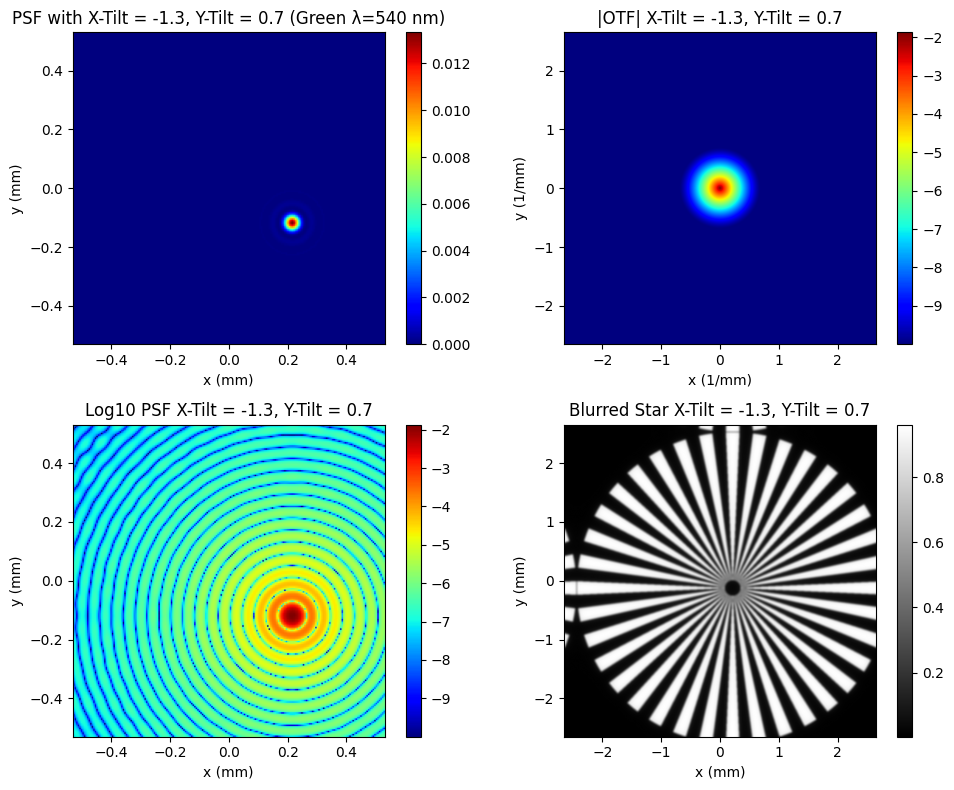

In [8]:
grid = 1001
dx = 0.0053  # mm


def simulate_psf_with_aberration(lambd):
    FX, FY = np.meshgrid(-lambd*zi*fx, -lambd*zi*fy)
    H_amp = (FX**2 + FY**2) < r**2

    z_sum = zernike(-lambd*zi*fx / r,  -lambd*zi*fy/ r, [2, 3], [-1.3, -0.7])
    phase = np.exp(-1j * 2 * np.pi * z_sum)

    H = H_amp * phase


    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))
    psf = np.abs(h)**2
    psf /= psf.sum()

    otf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf)))

    return psf, otf

# Simulate aberrated PSF
psf_green, otf_green = simulate_psf_with_aberration(wavelengths['green'])
otf_abs = np.abs(otf_green)

# Center and zoom
center = grid // 2
zoom = 100
psf_green_zoom = psf_green[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]

# Axes for plotting
extent = np.array([x.min(), x.max(), y.min(), y.max()])
zoom_extent = extent / 5.0

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im0 = axs[0, 0].imshow(psf_green_zoom, cmap='jet', extent=zoom_extent)
axs[0, 0].set_title("PSF with X-Tilt = -1.3, Y-Tilt = 0.7 (Green λ=540 nm)")
axs[0, 0].set_xlabel("x (mm)")
axs[0, 0].set_ylabel("y (mm)")
fig.colorbar(im0, ax=axs[0, 0])

im1 = axs[1, 0].imshow(np.log10(psf_green_zoom + 1e-10), cmap='jet', extent=zoom_extent)
axs[1, 0].set_title("Log10 PSF X-Tilt = -1.3, Y-Tilt = 0.7")
axs[1, 0].set_xlabel("x (mm)")
axs[1, 0].set_ylabel("y (mm)")
fig.colorbar(im1, ax=axs[1, 0])

im2 = axs[0, 1].imshow(otf_abs, cmap='jet', extent=extent)
axs[0, 1].set_title("|OTF| X-Tilt = -1.3, Y-Tilt = 0.7")
axs[0,1].set_xlabel("x (1/mm)")
axs[0, 1].set_ylabel("y (1/mm)")
fig.colorbar(im1, ax=axs[0, 1])

star_fft = np.fft.fft2(star)
psf_fft = np.fft.fft2(np.fft.ifftshift(psf_green))
blurred_star = np.real(np.fft.ifft2(star_fft * psf_fft))

im3 = axs[1, 1].imshow(blurred_star, cmap='gray', extent=extent)
axs[1, 1].set_title("Blurred Star X-Tilt = -1.3, Y-Tilt = 0.7")
axs[1, 1].set_xlabel("x (mm)")
axs[1, 1].set_ylabel("y (mm)")
fig.colorbar(im3, ax=axs[1, 1])

plt.tight_layout()
plt.show()

The aberration in this image introduces both an x-tilt and y-tilt, causing the PSF to shift down and to the right, resulting in a star pattern that is uncentered, but clear and sharp. The previously simulated aberration introduced only an x-tilt, causing a horizontal shift of the PSF and the star pattern along the x-axis. Therefore, introducing both x- and y-tilts caused a combined shift in both directions; however, the sharpness in both images was not degraded because of the magnitude of the OTF, demonstrating that the spatial frequencies were preserved, even though the phase was tilted in both directions, resulting in PSF displacement. In the blurred star image, the star is shifted in both directions but remains sharp, which is similar to the previous simulation, but with a greater shift in different directions.



<div class="alert alert-block alert-success">
<font color=black>

3. Simulate a defocus of coefficient `1/(np.sqrt(3)*2)`, (This number represents exactly one wavelength of defocus). Show the PSF and log10 PSF, both zoomed in on the central 201 by 201 elements. Also plot the BOTH the real values and absolute values of the OTF, as well as the star pattern blurred by this system. What do you observe in the star pattern in terms of the bright and dark spokes as you go from the periphery to the center of the image? What is causing this? (Hint: look at the real-valued OTF.)

</font>
</div>

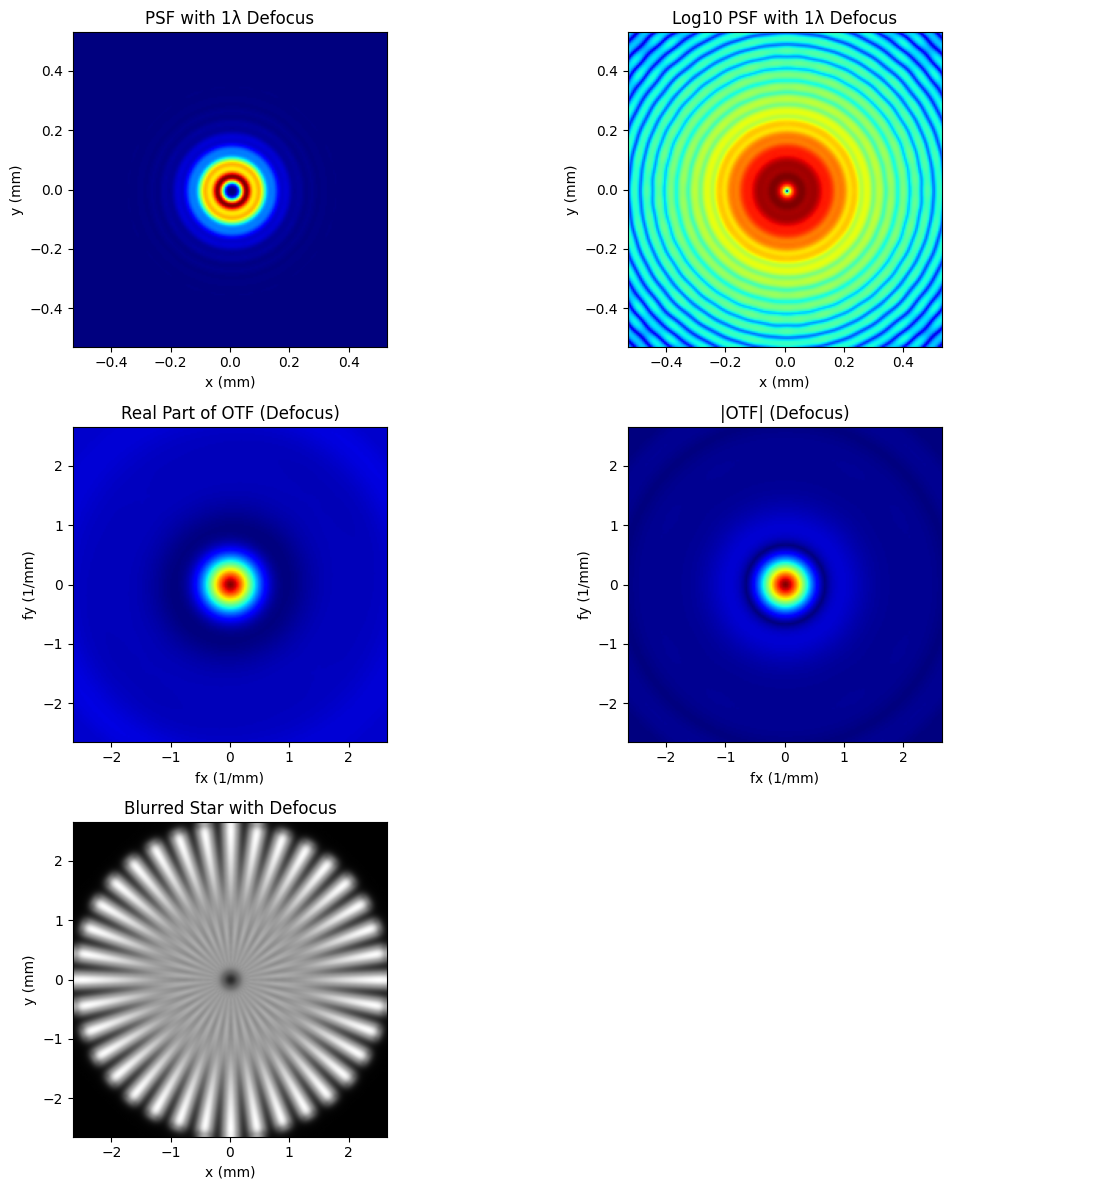

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from zernike import zernike
from functions import make_star

grid = 1001
dx = 0.0053  # mm
zi = 300  # mm
r = 2     # mm
wavelengths = {'green': 540e-6}  # mm (540 nm)

x = np.linspace(-2.65, 2.65, grid)
y = np.linspace(-2.65, 2.65, grid)
X, Y = np.meshgrid(x, y)
fx = np.fft.fftshift(np.fft.fftfreq(grid, d=dx))
fy = np.fft.fftshift(np.fft.fftfreq(grid, d=dx))

# Center and plotting
center = grid // 2
zoom = 100
extent = np.array([x.min(), x.max(), y.min(), y.max()])
zoom_extent = extent / 5.0

# Load Zernike index
zernike_index = np.load("/content/drive/MyDrive/1. EN.580.494.01 Build an Imager/Build_Imager/Lab4/zernike_index.npy")

# Load star (dummy star if make_star is unavailable)
from functions import make_star

x_img = np.linspace(-2.65, 2.65, grid)
y_img = np.linspace(-2.65, 2.65, grid)
star = make_star(x_img, y_img)

# Defocus simulation: Noll index 4 corresponds to defocus
def simulate_defocus_psf(defocus_coef):
    FX, FY = np.meshgrid(-wavelengths['green'] * zi * fx, -wavelengths['green'] * zi * fy)
    H_amp = (FX**2 + FY**2) < r**2

    z_sum = zernike(-wavelengths['green'] * zi * fx / r,
                    -wavelengths['green'] * zi * fy / r,
                    [4], [defocus_coef])

    phase = np.exp(-1j * 2 * np.pi * z_sum)
    H = H_amp * phase

    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))
    psf = np.abs(h)**2
    psf /= psf.sum()
    otf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf)))

    return psf, otf

# Defocus coefficient = 1 / (sqrt(3) * 2)
defocus_coef = 1 / (np.sqrt(3) * 2)
psf_defocus, otf_defocus = simulate_defocus_psf(defocus_coef)

# Zoom into PSF
psf_zoom = psf_defocus[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]

# Star convolution
star_fft = np.fft.fft2(star)
psf_fft = np.fft.fft2(np.fft.ifftshift(psf_defocus))
blurred_star = np.real(np.fft.ifft2(star_fft * psf_fft))

# Prepare OTF visualizations
otf_abs = np.abs(otf_defocus)
otf_abs_zoom = otf_abs[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]
otf_real = np.real(otf_defocus)
otf_real_zoom = otf_real[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]

# Plot all required outputs
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].imshow(psf_zoom, cmap='jet', extent=zoom_extent)
axs[0, 0].set_title("PSF with 1λ Defocus")
axs[0, 0].set_xlabel("x (mm)")
axs[0, 0].set_ylabel("y (mm)")

axs[0, 1].imshow(np.log10(psf_zoom + 1e-10), cmap='jet', extent=zoom_extent)
axs[0, 1].set_title("Log10 PSF with 1λ Defocus")
axs[0, 1].set_xlabel("x (mm)")
axs[0, 1].set_ylabel("y (mm)")

axs[1, 0].imshow(otf_real_zoom, cmap='jet', extent=extent)
axs[1, 0].set_title("Real Part of OTF (Defocus)")
axs[1, 0].set_xlabel("fx (1/mm)")
axs[1, 0].set_ylabel("fy (1/mm)")

axs[1, 1].imshow(otf_abs_zoom, cmap='jet', extent=extent)
axs[1, 1].set_title("|OTF| (Defocus)")
axs[1, 1].set_xlabel("fx (1/mm)")
axs[1, 1].set_ylabel("fy (1/mm)")

axs[2, 0].imshow(blurred_star, cmap='gray', extent=extent)
axs[2, 0].set_title("Blurred Star with Defocus")
axs[2, 0].set_xlabel("x (mm)")
axs[2, 0].set_ylabel("y (mm)")

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


As you go from the periphery to the center of the image, the star pattern becomes more blurred, where the bright and dark spokes alternate and the resolution decreases as you move towards the center. This is caused by the oscillations in the real-valued OTF, which oscillate between positive and negative values at different spatial frequencies, leading to destructive interference and reduced transmission of lower frequencies near the center of the star. Therefore, high and mid frequency details are better preserved than at low frequencies, as seen in the center.


<div class="alert alert-block alert-success">
<font color=black>

4. Simulate a defocus of coefficient 0.5. Show the PSF and log10 PSF, both zoomed in on the central 201 by 201 elements. Also plot the real values and absolute values of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image and compare to the previous defocus simulation.

</font>
</div>

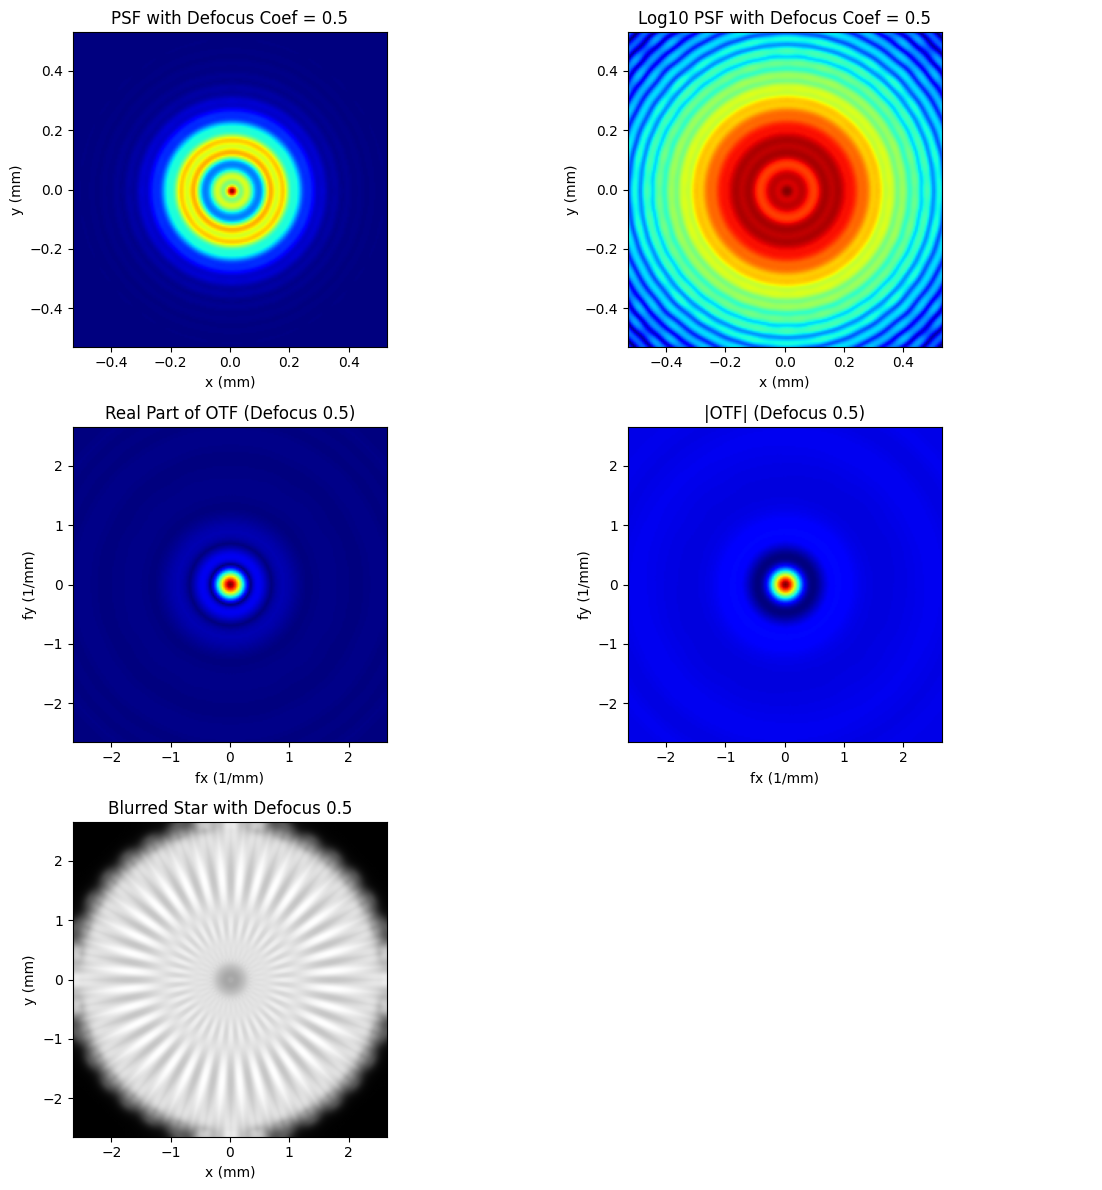

In [10]:
# Redefine the simulate_psf_with_defocus function for coefficient 0.5 (vs 1/√3 * 2 ≈ 0.2887)
def simulate_defocus_psf_fixed(defocus_coef):
    FX, FY = np.meshgrid(-wavelengths['green'] * zi * fx, -wavelengths['green'] * zi * fy)
    H_amp = (FX**2 + FY**2) < r**2

    z_sum = zernike(-wavelengths['green'] * zi * fx / r,
                    -wavelengths['green'] * zi * fy / r,
                    [4], [defocus_coef])  # Defocus: Noll index 4

    phase = np.exp(-1j * 2 * np.pi * z_sum)
    H = H_amp * phase

    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))
    psf = np.abs(h)**2
    psf /= psf.sum()
    otf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf)))

    return psf, otf

# Run simulation with defocus coefficient = 0.5
psf_defocus_05, otf_defocus_05 = simulate_defocus_psf_fixed(0.5)

# Zoomed PSF view
psf_zoom_05 = psf_defocus_05[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]
otf_abs_05 = np.abs(otf_defocus_05)
otf_abs_zoom = otf_abs_05[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]
otf_real_05 = np.real(otf_defocus_05)
otf_real_zoom = otf_real_05[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]

# Blurred star using PSF with 0.5 defocus
psf_fft_05 = np.fft.fft2(np.fft.ifftshift(psf_defocus_05))
blurred_star_05 = np.real(np.fft.ifft2(star_fft * psf_fft_05))

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].imshow(psf_zoom_05, cmap='jet', extent=zoom_extent)
axs[0, 0].set_title("PSF with Defocus Coef = 0.5")
axs[0, 0].set_xlabel("x (mm)")
axs[0, 0].set_ylabel("y (mm)")

axs[0, 1].imshow(np.log10(psf_zoom_05 + 1e-10), cmap='jet', extent=zoom_extent)
axs[0, 1].set_title("Log10 PSF with Defocus Coef = 0.5")
axs[0, 1].set_xlabel("x (mm)")
axs[0, 1].set_ylabel("y (mm)")

axs[1, 0].imshow(otf_abs_zoom, cmap='jet', extent=extent)
axs[1, 0].set_title("Real Part of OTF (Defocus 0.5)")
axs[1, 0].set_xlabel("fx (1/mm)")
axs[1, 0].set_ylabel("fy (1/mm)")

axs[1, 1].imshow(otf_real_zoom, cmap='jet', extent=extent)
axs[1, 1].set_title("|OTF| (Defocus 0.5)")
axs[1, 1].set_xlabel("fx (1/mm)")
axs[1, 1].set_ylabel("fy (1/mm)")

axs[2, 0].imshow(blurred_star_05, cmap='gray', extent=extent)
axs[2, 0].set_title("Blurred Star with Defocus 0.5")
axs[2, 0].set_xlabel("x (mm)")
axs[2, 0].set_ylabel("y (mm)")

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


The aberration in this image has a stronger defocus (coefficient = 5), causing more blurring across the star pattern. The aberration of the previous defocus simulation was smaller (coefficient = 0.289), causing less blurring and better preservation of the star spokes, especially near the edges. Compared to the previous simulation, the current defocus results in stronger oscillations and more significant attenuation in the real part of the OTF, causing more destructive interference and a greater loss of high and mid frequency details, which makes the image much more defocused.



<div class="alert alert-block alert-success">
<font color=black>

5. Simulate a y-coma of coefficient 0.1. Show the PSF and log10 PSF images, both zoomed in on the central 201 by 201 elements. Also plot the real values and absolute values of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image.

</font>
</div>

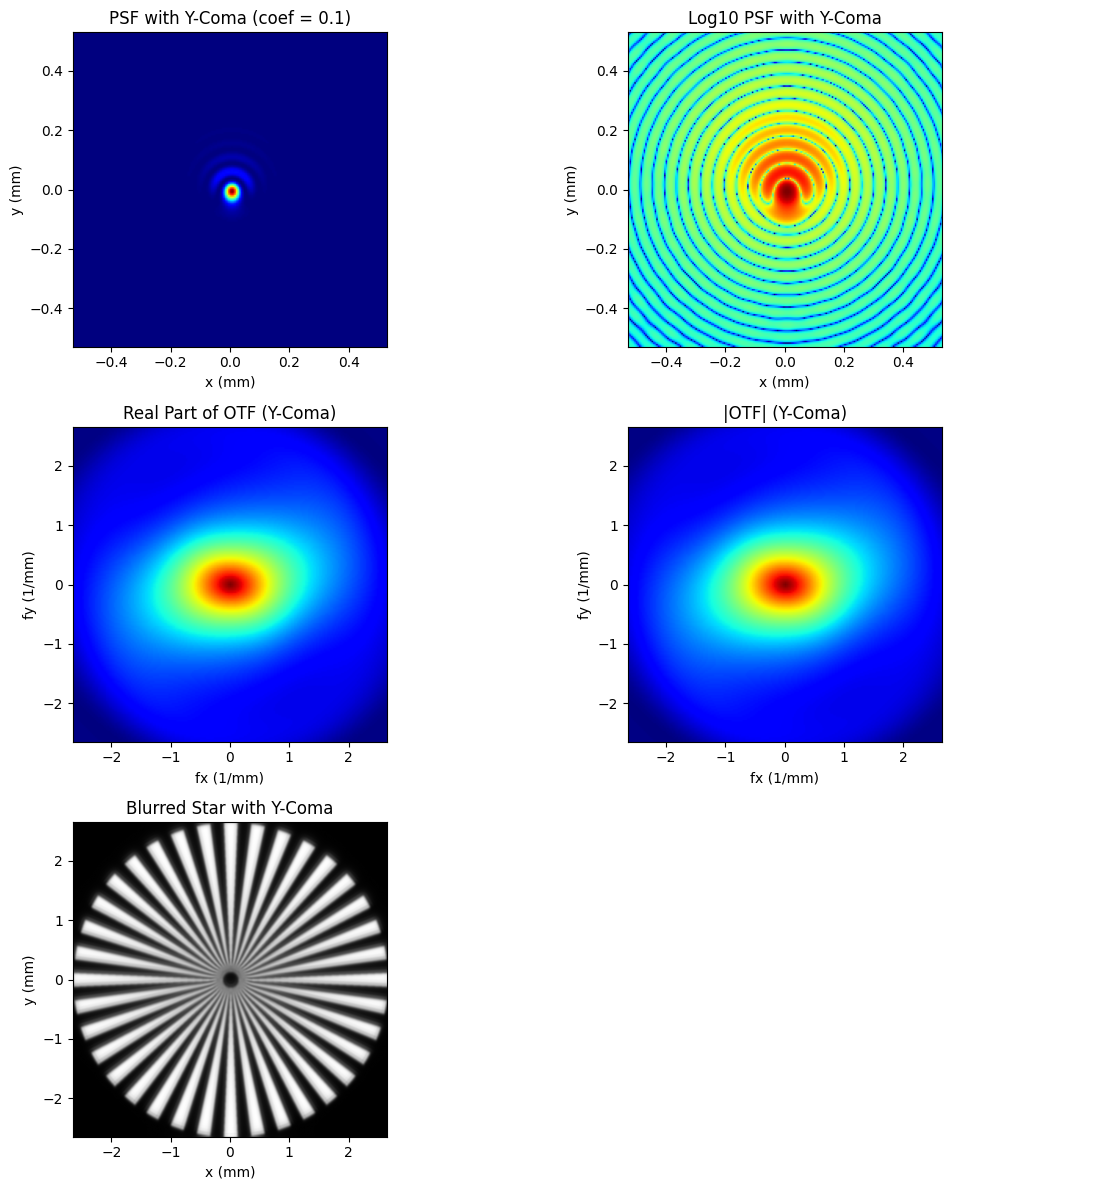

In [16]:
# Run coma simulation using Noll index 7 (y-coma) with coefficient 0.1
def simulate_coma_psf(coef):
    FX, FY = np.meshgrid(-wavelengths['green'] * zi * fx, -wavelengths['green'] * zi * fy)
    H_amp = (FX**2 + FY**2) < r**2

    z_sum = zernike(-wavelengths['green'] * zi * fx / r,
                    -wavelengths['green'] * zi * fy / r,
                    [7], [coef])  # Noll index 7 = y-coma

    phase = np.exp(-1j * 2 * np.pi * z_sum)
    H = H_amp * phase

    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))
    psf = np.abs(h)**2
    psf /= psf.sum()
    otf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf)))

    return psf, otf

# Simulate y-coma with coefficient 0.1
psf_coma, otf_coma = simulate_coma_psf(0.1)

# Get zoomed center
psf_zoom_coma = psf_coma[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]
otf_abs_coma = np.abs(otf_coma)
otf_abs_zoom = otf_abs_coma[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]
otf_real_coma = np.real(otf_coma)
otf_real_zoom = otf_real_coma[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]

# Blurred star using coma-affected PSF
psf_fft_coma = np.fft.fft2(np.fft.ifftshift(psf_coma))
blurred_star_coma = np.real(np.fft.ifft2(star_fft * psf_fft_coma))

# Plot
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].imshow(psf_zoom_coma, cmap='jet', extent=zoom_extent)
axs[0, 0].set_title("PSF with Y-Coma (coef = 0.1)")
axs[0, 0].set_xlabel("x (mm)")
axs[0, 0].set_ylabel("y (mm)")

axs[0, 1].imshow(np.log10(psf_zoom_coma + 1e-10), cmap='jet', extent=zoom_extent)
axs[0, 1].set_title("Log10 PSF with Y-Coma")
axs[0, 1].set_xlabel("x (mm)")
axs[0, 1].set_ylabel("y (mm)")

axs[1, 0].imshow(otf_real_zoom, cmap='jet', extent=extent)
axs[1, 0].set_title("Real Part of OTF (Y-Coma)")
axs[1, 0].set_xlabel("fx (1/mm)")
axs[1, 0].set_ylabel("fy (1/mm)")

axs[1, 1].imshow(otf_real_zoom, cmap='jet', extent=extent)
axs[1, 1].set_title("|OTF| (Y-Coma)")
axs[1, 1].set_xlabel("fx (1/mm)")
axs[1, 1].set_ylabel("fy (1/mm)")

axs[2, 0].imshow(blurred_star_coma, cmap='gray', extent=extent)
axs[2, 0].set_title("Blurred Star with Y-Coma")
axs[2, 0].set_xlabel("x (mm)")
axs[2, 0].set_ylabel("y (mm)")

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()



The PSF (top-left) shows a clear upward skew: the central lobe is displaced along the positive y-axis and a comet-like tail extends above the center.

In the log₁₀ PSF (top-right), concentric rings remain visible but are noticeably compressed below and stretched above the axis, highlighting the asymmetric phase distortion proportional to $\sin\theta$.

The real part of the OTF (middle-left) shifts energy toward positive fy while attenuating frequencies in the opposite direction, and the magnitude of the OTF (middle-right) appears elongated vertically, indicating reduced vertical resolution.

In the blurred star pattern (bottom), vertical spokes are smeared and lower in contrast compared to horizontal ones, especially toward the periphery, demonstrating that y-coma introduces directional blur and contrast loss primarily along the y-axis.  

<div class="alert alert-block alert-success">
<font color=black>

6. Simulate an x-coma of coefficient -0.2 together with a y-coma of coefficient 0.05. Show the PSF and log10 PSF images, both zoomed in on the central 201 by 201 elements. Also plot the real values and absolute values of the OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image and compare to the previously simulated aberration.

</font>
</div>

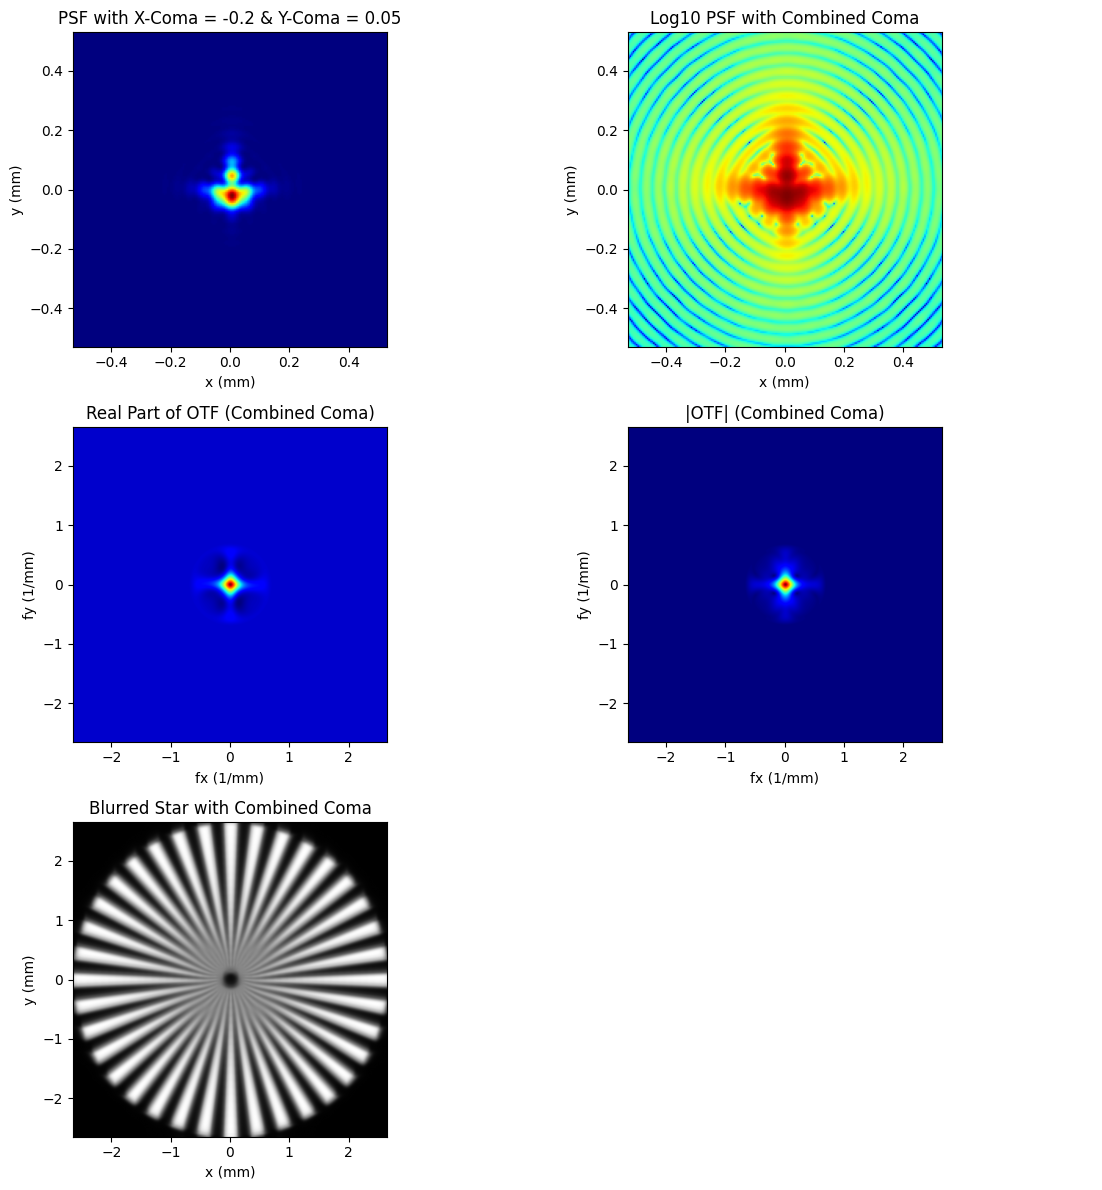

In [18]:
# Simulate combined x-coma (Noll index 6) and y-coma (Noll index 7)
def simulate_combined_coma_psf(x_coma_coef, y_coma_coef):
    FX, FY = np.meshgrid(-wavelengths['green'] * zi * fx, -wavelengths['green'] * zi * fy)
    H_amp = (FX**2 + FY**2) < r**2

    z_sum = zernike(-wavelengths['green'] * zi * fx / r,
                    -wavelengths['green'] * zi * fy / r,
                    [6, 7], [x_coma_coef, y_coma_coef])  # Noll indices for x- and y-coma

    phase = np.exp(-1j * 2 * np.pi * z_sum)
    H = H_amp * phase

    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))
    psf = np.abs(h)**2
    psf /= psf.sum()
    otf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf)))

    return psf, otf

# Simulate with x-coma = -0.2 and y-coma = 0.05
psf_combined_coma, otf_combined_coma = simulate_combined_coma_psf(-0.2, 0.05)

# Get zoomed center
psf_zoom_combined = psf_combined_coma[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]
otf_abs_combined = np.abs(otf_combined_coma)
otf_abs_zoom = otf_abs_combined[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]
otf_real_combined = np.real(otf_combined_coma)
otf_real_zoom = otf_real_combined[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]

# Blurred star
psf_fft_combined = np.fft.fft2(np.fft.ifftshift(psf_combined_coma))
blurred_star_combined = np.real(np.fft.ifft2(star_fft * psf_fft_combined))

# Plot results
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].imshow(psf_zoom_combined, cmap='jet', extent=zoom_extent)
axs[0, 0].set_title("PSF with X-Coma = -0.2 & Y-Coma = 0.05")
axs[0, 0].set_xlabel("x (mm)")
axs[0, 0].set_ylabel("y (mm)")

axs[0, 1].imshow(np.log10(psf_zoom_combined + 1e-10), cmap='jet', extent=zoom_extent)
axs[0, 1].set_title("Log10 PSF with Combined Coma")
axs[0, 1].set_xlabel("x (mm)")
axs[0, 1].set_ylabel("y (mm)")

axs[1, 0].imshow(otf_real_combined, cmap='jet', extent=extent)
axs[1, 0].set_title("Real Part of OTF (Combined Coma)")
axs[1, 0].set_xlabel("fx (1/mm)")
axs[1, 0].set_ylabel("fy (1/mm)")

axs[1, 1].imshow(otf_abs_combined, cmap='jet', extent=extent)
axs[1, 1].set_title("|OTF| (Combined Coma)")
axs[1, 1].set_xlabel("fx (1/mm)")
axs[1, 1].set_ylabel("fy (1/mm)")

axs[2, 0].imshow(blurred_star_combined, cmap='gray', extent=extent)
axs[2, 0].set_title("Blurred Star with Combined Coma")
axs[2, 0].set_xlabel("x (mm)")
axs[2, 0].set_ylabel("y (mm)")

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


In the top-left PSF image, we can see that the light distribution is no longer symmetric about the center. There is a noticeable skew in both x-direction. Additionally, an upward skew is observed from the small positive y-coma. The PSF is not radially symmetric and shows elongated tails in both x and y directions because of the coma.

The log-scaled PSF (top-right) reveals ripples and asymmetry more clearly. The rings are distorted and stretched more along the x-axis than the y-axis, consistent with x-coma being the dominant aberration.

The real part of the optical transfer function (middle-left) shows a central asymmetry, where spatial frequency components are shifted toward the negative fx axis. The magnitude of the OTF (middle-right) remains centered but exhibits slight elongation horizontally, indicating that transmission of spatial frequencies is no longer uniform.

In the blurred star image (bottom-left), the center spokes are still sharp but the outer spokes become stretched and blurred. This indicates that the coma distortion primarily affects features farther from the optical axis. Compared to previously simulated isolated y-coma, the dominant x-coma here leads to more horizontal asymmetry rather than vertical.

Overall, the combined coma simulation produces an image degradation that is directionally biased, with most of the distortion appearing in the x-direction, and a milder vertical contribution from y-coma.

Compared with the y-coma simulation in Q5, which was Y coma, the PSF shows a vertical shift with the energy displaced along the fy-axis, resulting in vertical smearing in the blurred star image while maintaining overall radial symmetry. In contrast, the combined x-coma and y-coma simulation in this question created a PSF with distortion along both fx and fy axes. The OTF for the combined case shows a broader and more complex shift compared to the single-axis displacement seen with y-coma alone. As a result, the blurred star image under combined coma shows more severe distortion away from the center.


<div class="alert alert-block alert-success">
<font color=black>

7. One last simulation! Let’s look at the composition of many aberrations together. Simulate mode indices `[4, 5, 6, 7, 11]` with coefficients `[0.1, -0.2, 0.05, 0.2, 0.1]`. Show the PSF and log10 PSF images, both zoomed in on the central 201 by 201 elements. Also plot the real values and absolute values of OTF, as well as the star pattern blurred by this system. Describe the effect of this aberration on the image.

</font>
</div>

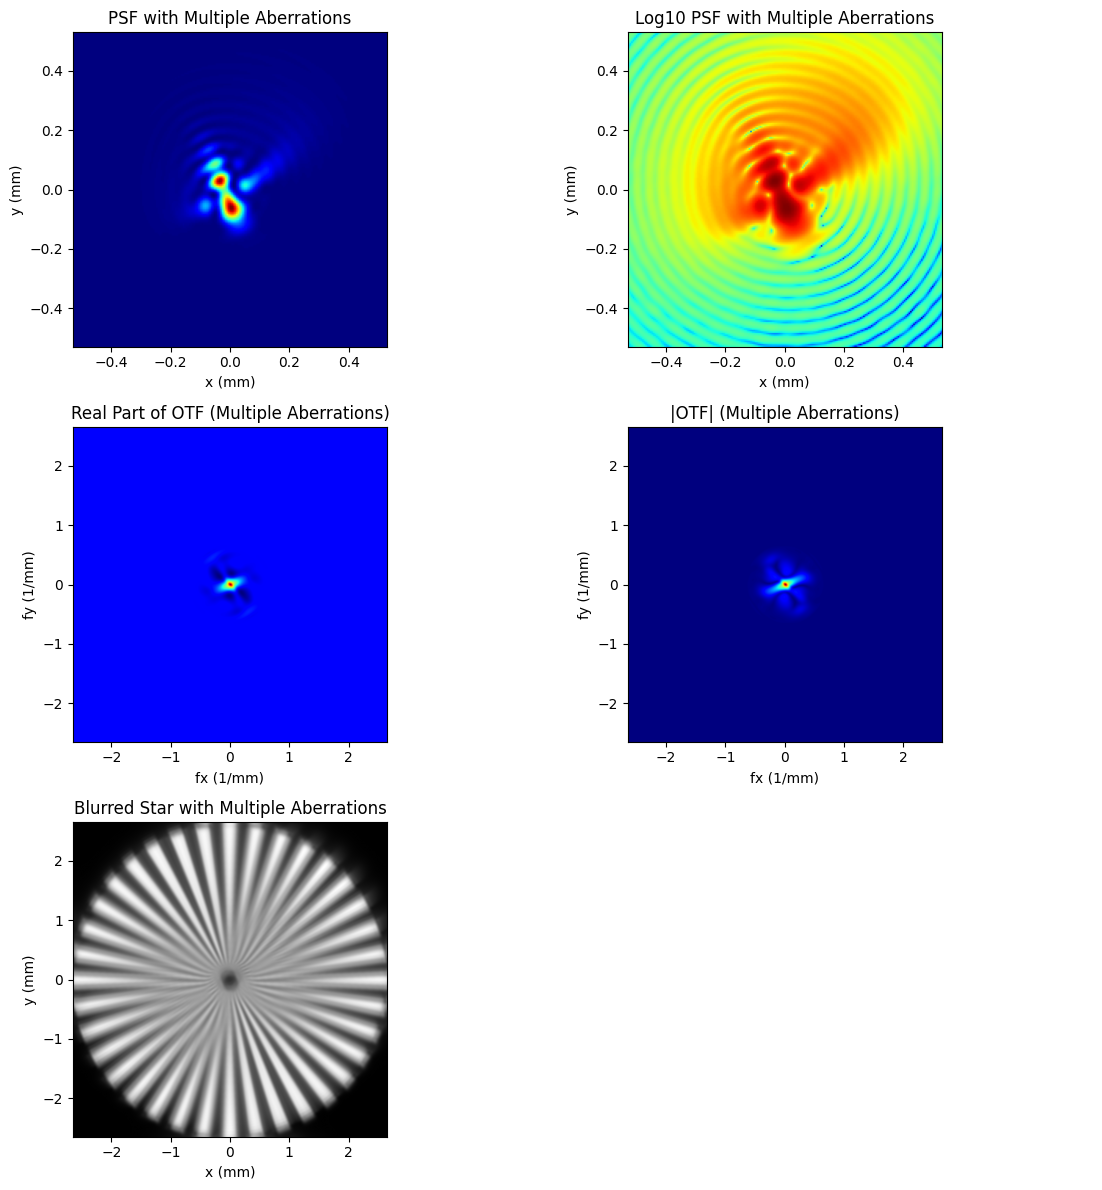

In [13]:
# Simulate composition of multiple aberrations
def simulate_multiple_aberrations(mode_indices, coeffs):
    FX, FY = np.meshgrid(-wavelengths['green'] * zi * fx, -wavelengths['green'] * zi * fy)
    H_amp = (FX**2 + FY**2) < r**2

    z_sum = zernike(-wavelengths['green'] * zi * fx / r,
                    -wavelengths['green'] * zi * fy / r,
                    mode_indices, coeffs)

    phase = np.exp(-1j * 2 * np.pi * z_sum)
    H = H_amp * phase

    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))
    psf = np.abs(h)**2
    psf /= psf.sum()
    otf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf)))

    return psf, otf

# Run simulation with modes [4, 5, 6, 7, 11] and their respective coefficients
mode_indices = [4, 5, 6, 7, 11]
coeffs = [0.1, -0.2, 0.05, 0.2, 0.1]
psf_combo, otf_combo = simulate_multiple_aberrations(mode_indices, coeffs)

# Extract zoomed-in region and OTF parts
psf_zoom_combo = psf_combo[center - zoom:center + zoom + 1, center - zoom:center + zoom + 1]
otf_abs_combo = np.abs(otf_combo)
otf_real_combo = np.real(otf_combo)

# Blurred star using this combination PSF
psf_fft_combo = np.fft.fft2(np.fft.ifftshift(psf_combo))
blurred_star_combo = np.real(np.fft.ifft2(star_fft * psf_fft_combo))

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].imshow(psf_zoom_combo, cmap='jet', extent=zoom_extent)
axs[0, 0].set_title("PSF with Multiple Aberrations")
axs[0, 0].set_xlabel("x (mm)")
axs[0, 0].set_ylabel("y (mm)")

axs[0, 1].imshow(np.log10(psf_zoom_combo + 1e-10), cmap='jet', extent=zoom_extent)
axs[0, 1].set_title("Log10 PSF with Multiple Aberrations")
axs[0, 1].set_xlabel("x (mm)")
axs[0, 1].set_ylabel("y (mm)")

axs[1, 0].imshow(otf_real_combo, cmap='jet', extent=extent)
axs[1, 0].set_title("Real Part of OTF (Multiple Aberrations)")
axs[1, 0].set_xlabel("fx (1/mm)")
axs[1, 0].set_ylabel("fy (1/mm)")

axs[1, 1].imshow(otf_abs_combo, cmap='jet', extent=extent)
axs[1, 1].set_title("|OTF| (Multiple Aberrations)")
axs[1, 1].set_xlabel("fx (1/mm)")
axs[1, 1].set_ylabel("fy (1/mm)")

axs[2, 0].imshow(blurred_star_combo, cmap='gray', extent=extent)
axs[2, 0].set_title("Blurred Star with Multiple Aberrations")
axs[2, 0].set_xlabel("x (mm)")
axs[2, 0].set_ylabel("y (mm)")

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


The resulting PSF is highly asymmetric compared to the PSF without aberrations. This simulation had multiple off-axis lobes which shows strong phase distortion across the pupil. In the log-scaled PSF, interference rings are heavily distorted, which is explained since there are multiple aberrations that affecting different spatial regions.

The real part of the OTF shows suppression and asymmetry along both fx and fy axes, while the absolute OTF magnitude confirms a significant reduction in high-frequency content.

 In the blurred star pattern, spokes become uneven in brightness and spacing, with noticeable directional blurring and asymmetry away from the center.

Overall, combining multiple aberrations results in a more severe degradation of image sharpness and radial symmetry compared to isolated aberrations, consistent with constructive interference of phase errors across the pupil.
